In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from math import log2, log10
import pickle
import cobra
from glob import glob
import numpy as np
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline

/home/sbrg-cjlloyd/cobrapy/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


In [22]:
aas = ['met__L', 'ser__L', 'phe__L', 'asn__L', 'thr__L',
       'ile__L', 'asp__L', 'trp__L', 'cys__L', 'ala__L', 
       'glu__L', 'gln__L', 'arg__L', 'leu__L', 'pro__L', 
       'val__L', 'lys__L', 'gly', 'tyr__L', 'his__L']

In [2]:
met_to_name = {'2dmmq8': '2-Demethyl-\nmenaquinone 8',
 '2fe2s': '2Fe-2S',
 '4fe4s': '4Fe-4S',
 'adocbl': 'Adenosyl-\ncobalamin',
 'ala__L': 'L-Alanine',
 'arg__L': 'L-Arginine',
 'asn__L': 'L-Asparagine',
 'asp__L': 'L-Aspartate',
 'bmocogdp': 'bis-MGD',
 'btn': 'Biotin',
 'coa': 'Coenzyme A',
 'cys__L': 'L-Cysteine',
 'gln__L': 'L-Glutamine',
 'glu__L': 'L-Glutamate',
 'gly': 'Glycine',
 'gthox': 'Glutathione',
 'hemeO': 'Heme O',
 'his__L': 'L-Histidine',
 'ile__L': 'L-Isoleucine',
 'leu__L': 'L-Leucine',
 'met__L': 'L-Methionine',
 'mqn8': 'Menaquinone 8',
 'nac': 'Niacin',
 'nad': 'NAD',
 'nadp': 'NADP',
 'phe__L': 'L-Phenylalanine',
 'pheme': 'Protoheme',
 'pnto__R': 'Pantothenate',
 'pro__L': 'L-Proline',
 'pydx5p': "Pyridoxal \n 5'-phosphate",
 'pydxn': "Pyridoxine",
 'q8': 'Ubiquinone-8',
 'ribflv': 'Riboflavin',
 'ser__L': 'L-Serine',
 'sheme': 'Siroheme',
 'thf': 'Tetrahydrofolate',
 'thmpp': 'Thiamine \n diphosphate',
 'thm': 'Thiamin', 
 'thr__L': 'L-Threonine',
 'trp__L': 'L-Tryptophan',
 'tyr__L': 'L-Tyrosine',
 'val__L': 'L-Valine'}

In [25]:
synonym_df = pd.DataFrame() 
cof_index = 0
aa_index = 0
for i, v in met_to_name.items():
    if i in aas:
        synonym_df.loc[aa_index, 'aa'] = v
        synonym_df.loc[aa_index, 'aa_bigg'] = i
        aa_index += 1
    else:
        synonym_df.loc[cof_index, 'cofactor'] = v
        synonym_df.loc[cof_index, 'cof_bigg'] = i
        cof_index+=1
synonym_df.to_csv('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Supplement/nutrient_to_name.csv')

In [3]:
with open('/home/sbrg-cjlloyd/multime/multime/iJL1678b_ML_KO_keffs.pickle', 'rb') as f:
    me = pickle.load(f)

In [4]:
mets_to_skip = ['glu__L', 'gln__L', 'asn__L', 'arg__L', 'thr__L', 'skm']

In [5]:
from optaux.resources.update_mpl_rcparams import update_rcparams
update_rcparams()
plt.rcParams['figure.figsize'] = [15.0, 5.0]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['legend.facecolor'] = 'w'

In [7]:
for kind in ['fluxes']:
    joined = pd.DataFrame()
    for file in glob('./titration_new/%s.csv' % kind):
        print(file)
        df = pd.read_csv(file, index_col=0)
        joined = joined.join(df, how='outer')
cons_df = joined.T[~ joined.columns.isin(['default'])].T
default_series = joined['default']

cons_df = cons_df.T
cons_df.index.name = 'metabolite'


./titration_new/fluxes.csv


In [8]:
df = cons_df.reset_index()
for i in df.index:
    df.loc[i, 'uptake'] = float(df.loc[i, 'metabolite'].split('_')[-1])
    df.loc[i, 'metabolite'] = '_'.join(df.loc[i, 'metabolite'].split('_')[:-1])

In [9]:
def change_index_to_uptake_fraction(df):
    cons_pca_df = df.copy().T
    cons_pca_df['metabolite'] = list(cons_pca_df.index)
    cons_pca_df['uptake'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[-1]).map(float)
    cons_pca_df['metabolite'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[0])
    # Normalize to fraction of max uptake
    for i in cons_pca_df.metabolite.unique():
        met_index = cons_pca_df.index[cons_pca_df.metabolite == i]
        cons_pca_df.loc[met_index, 'uptake'] = cons_pca_df.loc[met_index, 'uptake'] / cons_pca_df.loc[met_index, 'uptake'].max()
    cons_pca_df['new_index'] = cons_pca_df['metabolite'] + '(' + cons_pca_df['uptake'].map(lambda x: round(x, 2)).map(str) + ')'
    cons_pca_df.set_index('new_index', inplace=True, drop=True)
    
    return cons_pca_df

In [10]:
def return_individual_comparison(temp_df, default_series, substrate=None, substrate_carbons=0, kind='growth', at_max=False):
    if at_max:
        temp_df = temp_df[temp_df.uptake == temp_df.uptake.max()]
    default_gr = default_series['biomass_dilution']
    if kind == 'growth':
        y = temp_df.biomass_dilution.values
        return y / default_gr
    elif kind == 'iron_uptake':
        uptake_activity = abs(temp_df['EX_fe3_e'] / temp_df['biomass_dilution'])    
        default_iron_uptake = abs(default_series['EX_fe3_e'] / default_gr)
        return abs(uptake_activity / default_iron_uptake)
    elif kind == 'glucose':
        gluc_uptake = abs(temp_df['EX_glc__D_e'] / temp_df['biomass_dilution'])
        default_gluc_uptake = abs(default_series['EX_glc__D_e'] / default_gr)
        return gluc_uptake / default_gluc_uptake
    elif kind == 'yield':
        y = temp_df.biomass_dilution.values
        gluc_uptake = abs(temp_df['EX_glc__D_e'])
        default_gluc_uptake = abs(default_series['EX_glc__D_e'])
        return (y/(gluc_uptake*6 + abs(temp_df[substrate] * substrate_carbons))) / (default_gr / default_gluc_uptake/6)
    


In [11]:
def get_protein_distribution(model, solution=None, cog_df=None, groupby='COG'):
    """
    Return the synthesis flux for each protein.

    First implementation-can be improved
    """
    protein_dict = defaultdict(float)
    if not solution:
        solution = model.solution
    else:
        model.solution = solution
    ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/ecolime/ecolime/building_data/iJO1366.json')
    
    translation = model.get_translation_flux(solution=solution)

    if groupby == 'COG' and cog_df is not None:
        
        for protein, flux in translation.items():
            protein_mass = model.metabolites.get_by_id('protein_' + protein).formula_weight
            if protein != 'dummy':
                if protein in cog_df.index:
                    try:
                        cog = cog_df.loc[protein, 'COG description'].values[0]
                    except:
                        cog = cog_df.loc[protein, 'COG description']
                else:
                    cog = 'No COG'

                protein_dict[cog] += protein_mass * flux
            else:
                protein_dict['dummy'] += protein_mass * flux

    elif groupby == 'Metabolic_Subsystem':
        for protein_id, flux in translation.items():
            if flux <= 0:
                continue
            subsystem_dict = dict()
            protein = model.metabolites.get_by_id('protein_' + protein_id)
            protein_mass = protein.formula_weight
            met_fluxes = 0
            if protein_id not in ijo.genes:
                continue
            for r in ijo.genes.get_by_id(protein_id).reactions:
                if r.id not in me.process_data:
                    continue
                for me_rxn in me.process_data.get_by_id(r.id).parent_reactions:
                    # Flux is a function of keff, so account for that
                    if abs(me_rxn.x)>1e-10:
                        subsystem_dict[r.subsystem] = abs(me_rxn.x) / me_rxn.keff
                        met_fluxes += abs(me_rxn.x) / me_rxn.keff
            for sub, met_flux in subsystem_dict.items():
                protein_dict[sub] += protein_mass * flux * (met_flux/met_fluxes)
    else:
        raise Exception('groupby flag is not "COG" or "Metabolic_Subsystem')

    return protein_dict

# Plot global characteristic

/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


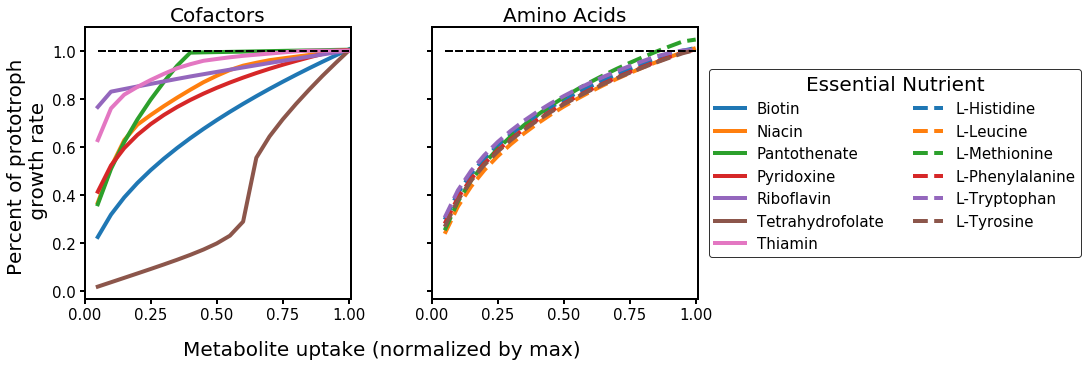

In [14]:
# W/ changing abundance
fig, all_axes = plt.subplots(1, 2, sharey=True, figsize=(11,5),
                             sharex=True)

all_handles = []
all_labels = []
for q, kind in enumerate(['cofactors', 'aas']):
    for met, temp_df in df.groupby('metabolite'):
        if kind == 'aas' and met not in aas:
            continue
        elif kind == 'cofactors' and met in aas:
            continue
        #q = temp_df
        if met in mets_to_skip:
            continue
        if kind == 'aas':
            ax = all_axes[1]
            ax.set_title('Amino Acids')
        elif kind == 'cofactors':
            ax = all_axes[0]
            ax.set_title('Cofactors')
        else:
            raise Exception('Kind %s not valid' % kind)
        if kind == 'aas':
            style='--'
            size=4
            marker=None
        else:
            style='-'
            size=4
            marker=None
        temp_df.uptake = temp_df.uptake.map(float)
        temp_df.biomass_dilution = temp_df.biomass_dilution.map(float)
        temp_df = temp_df.sort_values('uptake')

        # Plot growth rate
        x = (temp_df.uptake/ temp_df.uptake.max()).values

        ax.plot(x, return_individual_comparison(temp_df, default_series), 
                linestyle=style, linewidth=size,
                marker=marker, label=met_to_name[met])
        ax.plot([1/20, 1], [1]*2, 'k--', linewidth=2)
            
        
        
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)
    ax.set_facecolor('w')
    #if kind == 'cofactors':
    ax.set_xlim(0, 1.01)

all_axes[0].set_ylabel('Percent of prototroph \n growth rate')
lgd = all_axes[1].legend(all_handles, all_labels, bbox_to_anchor=(1.01, .5),
                         loc='center left', ncol=2, fontsize=15, 
                         facecolor='w', title='Essential Nutrient', title_fontsize=20)


    
fig.text(.5, -.03, 'Metabolite uptake (normalized by max)', ha='center', size=20)
#fig.text(.5, 1, '      Amino Acids', ha='center', size=30)
#fig.text(.5, .5, '      Cofactor', ha='center', size=30)
#fig.tight_layout()
fig.subplots_adjust(wspace=.3, hspace=.4)
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/auxotroph_titration_growth.svg',
           bbox_extra_artists=(lgd,), bbox_inches='tight')

In [105]:
pd.DataFrame(x, return_individual_comparison(q, default_series))

,0
0.018272,0.05
0.036548,0.10
0.054846,0.15
0.073217,0.20
0.091752,0.25
0.110612,0.30
0.130051,0.35
0.150492,0.40
0.172668,0.45
0.198031,0.50


## PCA

In [13]:
with open('/home/sbrg-cjlloyd/multime/multime/iJL1678b_ML_KO_keffs.pickle', 'rb') as f:
    me = pickle.load(f)
ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/ecolime/ecolime/building_data/iJO1366.json')

In [14]:

norm_df = (cons_df.T / abs(cons_df['biomass_dilution']).T).copy()
norm_df[abs(norm_df) < 1e-20] = 0

# only include reactions from above (exclude those filtered in mets to skip)
for i in list(norm_df.columns):
    if '_'.join(i.split("_")[:-1]) in mets_to_skip:
        norm_df.drop(i, axis=1, inplace=True)
    
# find
filter_df = norm_df.copy()
filter_df[abs(filter_df)>0] =1
# TODO why is this <=1 and not == 0
rxns_to_make_zero = filter_df[filter_df.T.sum()  <= 1 ].index


pca_dict = {}
for met in norm_df.dropna(how='any').columns:
    #norm_df.loc[rxns_to_make_zero, met] = 0
    sol = cobra.core.Solution(.1, x_dict=norm_df[met].to_dict(), status='optimal')
    pca_dict[met] = me.get_metabolic_flux(solution=sol)
    

In [15]:
# Create dataframe from above and filter
# Find reactions perfectly correlated across all conditions and remove them from analysis

pca_df = pd.DataFrame(pca_dict)

corr_df = pca_df.T.corr()

corr_df = corr_df.dropna(how='all', axis=0)
corr_df = corr_df.dropna(how='all', axis=1)

correlated_dict = {}
rxns_to_exclude = []
for i in corr_df.columns:
    correlated_set = set()
    correlated_coset = corr_df[i][corr_df[i] > .99]
    if len(correlated_coset) > 1 and i not in rxns_to_exclude:
        correlated_rxns = list(correlated_coset.index)
        correlated_rxns.remove(i)
        correlated_dict[i] = correlated_rxns
        rxns_to_exclude.extend(correlated_rxns)
        
out_df = pca_df.loc[[i for i in pca_df.index if i not in rxns_to_exclude]]
pca_df = out_df.copy()

[0.29184556 0.12233292 0.07760402 0.06713209 0.05705391]
['phe', 'tyr', 'his', 'leu', 'met', 'trp', 'btn', 'nac', 'pnto', 'pydxn', 'ribflv', 'thf', 'thm']


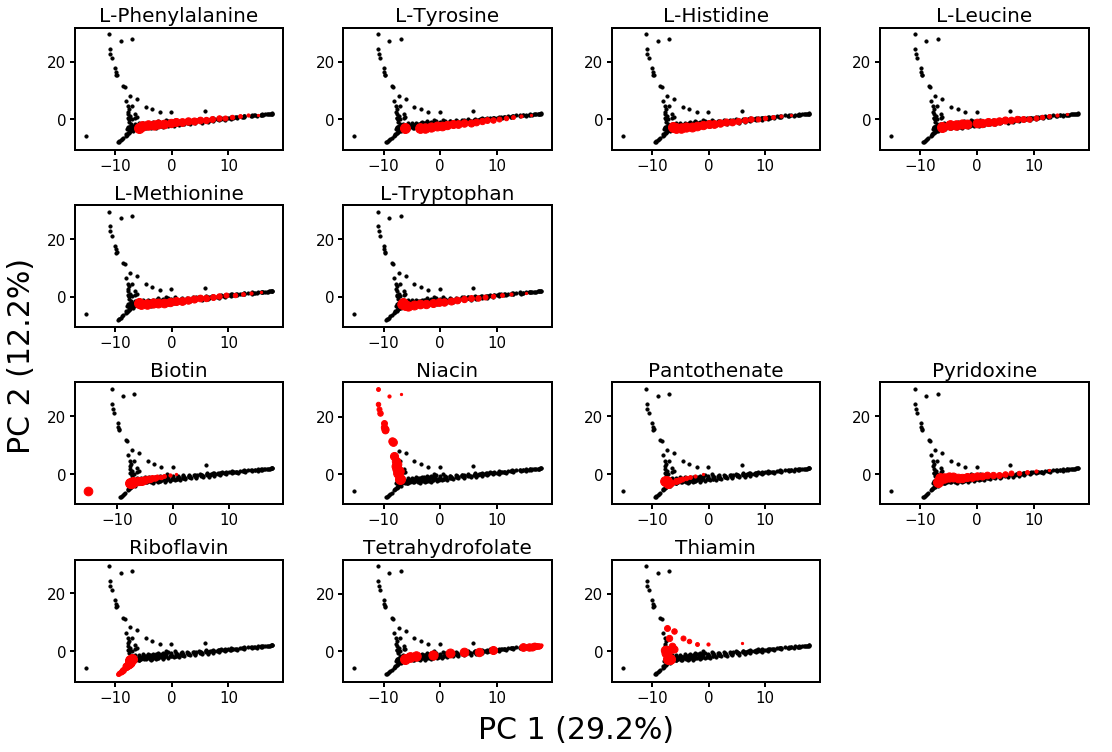

In [17]:

pca_df = pca_df.loc[[i for i in pca_df.index if 'DM_RNA' not in i and not i.startswith('EX_')]]
cons_pca_df = pca_df.copy().T

expression_values = preprocessing.StandardScaler().fit_transform(cons_pca_df)
pca = PCA(n_components=5)
a = pca.fit(expression_values)
len(a.components_[0])


print(pca.explained_variance_ratio_)

rxns =cons_pca_df.columns
#uptake_vals = np.array([float(i.split('_')[-1]) for i in cons_pca_df.index])
X_r = a.transform(expression_values)

component_dict = {}
for comp_num in [0, 1]:
    comp = a.components_[comp_num]
    component_dict['positive_%s' % comp_num] =  dict(zip(rxns[comp > (abs(np.median(comp)) + 2 * comp.std())].values, comp[comp > (abs(comp.mean()) + 2 * comp.std())]))
    component_dict['negative_%s' % comp_num] =  dict(zip(rxns[comp < -(abs(np.median(comp)) + 2 * comp.std())].values, comp[comp < -(abs(comp.mean()) + 2 * comp.std())]))

component_df = pd.DataFrame(component_dict).fillna(0)
for i in component_df.index:
    component_df.loc[i, 'min'] = cons_pca_df.T.loc[i].min()
    component_df.loc[i, 'max'] = cons_pca_df.T.loc[i].max()
    component_df.loc[i, 'avg'] = cons_pca_df.T.loc[i].mean()
    try:
        component_df.loc[i, 'subsystem'] = ijo.reactions.get_by_id(i).subsystem
    except:
        pass
component_df.to_csv('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Supplement/all_auxotroph_pca_weights.csv')

mets = set([i.split('_')[0] for i in cons_pca_df.index])
met_order = [i for i in mets if i + '__L' in aas] + sorted([i for i in mets if i+'__L' not in aas])
print(met_order)
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
row = 0
col = -1

def clear_remaining_cols(axes, row, col):
    for new_col in range(col+1, 4):
        axes[row][new_col].axis('off')
for met in met_order:
    for suffix in ['_c', '__L_c', '__R_c']:
        if met+suffix in me.metabolites:
            met_obj = me.metabolites.get_by_id(met+suffix)
    col+=1
    # Move to new row once we hit first cofactor (since sorted should always be biotin)
    if col == 4 or met == 'btn':
        clear_remaining_cols(axes, row, col-1)
        row += 1
        col = 0
    ax = axes[row][col]
    for i, uptake in enumerate(list(change_index_to_uptake_fraction(cons_pca_df.T).index)):#numerate(uptake_vals):
        if met in uptake:
            ax.scatter(X_r[i, 0], X_r[i, 1], c='r', s=100 * float(uptake.split('(')[-1].replace(')', '')),
                      zorder=3)
        else:
        #ax.text(X_r[i, 0], X_r[i, 1], '%.2f' % (uptake / uptake_vals.max()))
            ax.scatter(X_r[i, 0], X_r[i, 1], s=10, c='k')
    ax.set_title(met_to_name[met_obj.id.replace('_c', '')])
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
clear_remaining_cols(axes, row, col)
fig.tight_layout()
fig.text(.5, 0, 'PC 1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100), ha='center', va='top', fontsize=30)
fig.text(0, .5, 'PC 2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100), ha='right', va='center', fontsize=30, rotation=90)
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_mulitme_manuscript/Figures/pca_limitation.png')



## Cluster metabolic flux activity and assess protein allocation

In [18]:
cog_df = pd.read_csv('/home/sbrg-cjlloyd/ecolime/ecolime/characterization/data/cogs_ecoli_mg1655.csv',
                     encoding="ISO-8859-1")
cog_df = cog_df.set_index('locus')
cog_dict = {}
for met in cons_df.index:
    sol = cobra.core.Solution(.1, x_dict=cons_df.loc[met].to_dict(), status='optimal')
    cog_dict[met] = get_protein_distribution(me, solution=sol, cog_df=cog_df, groupby='Metabolic_Subsystem')


In [19]:
q = cons_df[[i for i in cons_df.columns if i.startswith('EX_')]].copy()
q['met'] = q.index.map(lambda x: x.split('_')[0])
for i, temp_df in q.groupby('met'):
    c = temp_df[[i for i in temp_df.columns if i !='met' and i not in ['EX_h_e', 'EX_meoh_e', 'EX_h2o_e', 
                                                                       'EX_5mtr_e', 'EX_co2_e', 'EX_ac_e', 'EX_glyclt_e']]]
    c = c[c>.0001].dropna(axis=1, how='all')
    if len(c.columns) == 0:
        continue
    print(c)

                           EX_akg_e
metabolite                         
gln__L_0.5129814589071651       NaN
gln__L_1.0259629178143301       NaN
gln__L_1.5389443767214952       NaN
gln__L_2.0519258356286603       NaN
gln__L_2.5649072945358253       NaN
gln__L_3.0778887534429904       NaN
gln__L_3.5908702123501555       NaN
gln__L_4.1038516712573205       NaN
gln__L_4.616833130164485        NaN
gln__L_5.12981458907165         NaN
gln__L_5.642796047978816        NaN
gln__L_6.155777506885981   0.430418
gln__L_6.668758965793145   0.944012
gln__L_7.18174042470031    1.457606
gln__L_7.694721883607476   1.971200
gln__L_8.207703342514641   2.484794
gln__L_8.720684801421806   2.998388
gln__L_9.23366626032897    3.511982
gln__L_9.746647719236135   4.025576
gln__L_10.259629178143301  4.539170
                           EX_akg_e
metabolite                         
glu__L_0.7800323724813325  0.307793
glu__L_1.560064744962665   0.528227
glu__L_2.3400971174439977  0.739556
glu__L_3.12012948992533    0

2619
2181


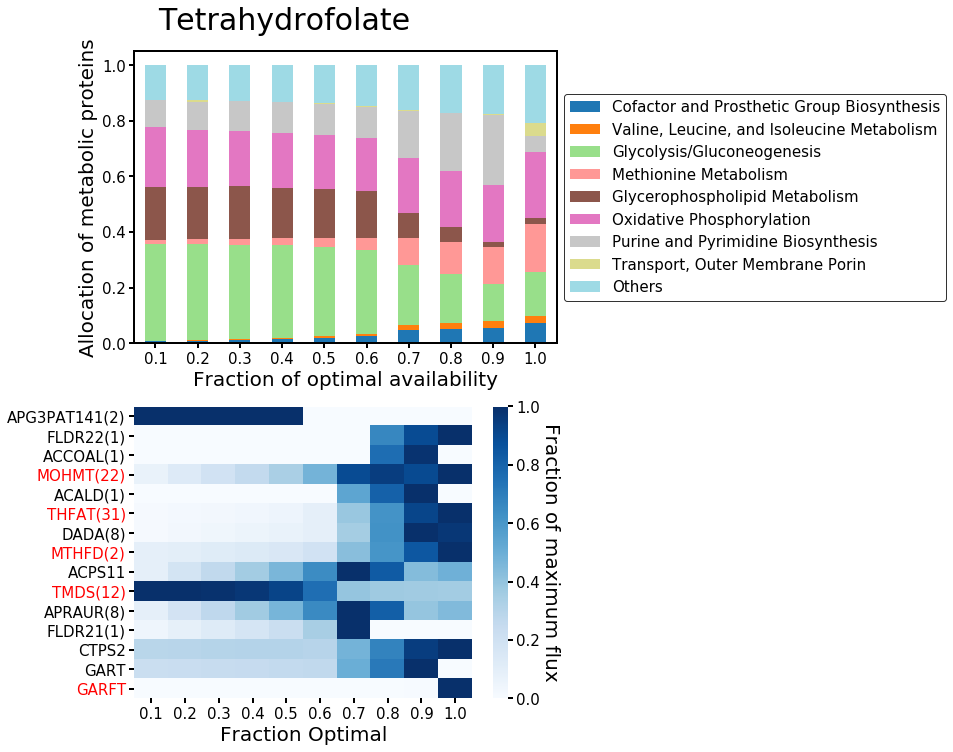

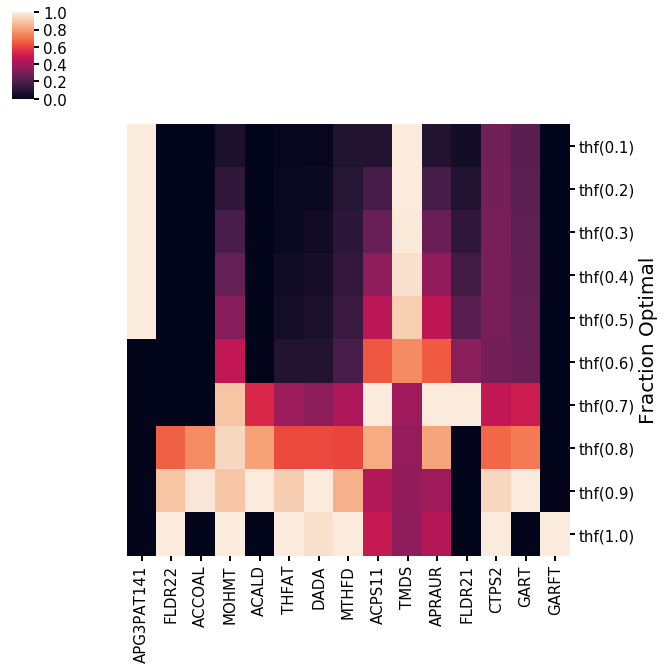

In [99]:
import seaborn as sns

rxn_df = pd.DataFrame(pca_dict)
rxn_df = rxn_df.loc[[i for i in rxn_df.index if 'DM_RNA' not in i]]

to_exclude= ['EX_ni2_e', 'EX_ca2_e', 'EX_na1_e', 'EX_k_e', 'EX_mn2_e', 'GLCt2pp', 'GLCptspp', 'EX_acald_e',
            'EX_zn2_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_meoh_e', 'EX_mg2_e', 'EX_h_e', 'EX_RNase_m5']

met_to_affected = pd.read_csv('vitamin_to_blocked_reactions.csv',index_col=0).rename(lambda x: x.split(',')[0])
met_to_affected.rename(lambda x: x.replace('nad', 'nac').replace('thmpp', 'thm').replace('pydx5p', 'pydxn'), inplace=True)
def filter_out_correlated_rxns(in_df, met):
    
    if met in met_to_affected.index:
        reactions_affected_by_auxotroph = met_to_affected.loc[met, '0'].split(', ')
    else:
        reactions_affected_by_auxotroph = []
    
    corr_df = in_df.T.corr()

    corr_df = corr_df.dropna(how='all', axis=0)
    corr_df = corr_df.dropna(how='all', axis=1)

    correlated_dict = {}
    rxns_to_exclude = []
    for i in corr_df.columns:
        correlated_set = set()
        correlated_coset = corr_df.loc[abs(corr_df[i]) > .999, i]
        if len(correlated_coset) > 1 and i not in rxns_to_exclude:
            correlated_rxns = list(correlated_coset.index)
            key = None
            for r in correlated_rxns:
                if r in list(reactions_affected_by_auxotroph):
                    key = r
                if r.startswith('EX_') and not key:
                    key = r
                    
            if not key:
                key = correlated_rxns[0]
            # todo commenting this out might cause problems, not sure why
            #if not key.startswith("EX_"):
            correlated_rxns.remove(key)
            
            correlated_dict[key] = correlated_rxns
            rxns_to_exclude.extend(correlated_rxns)

    print(len(in_df.index))
    out_df = in_df.loc[[i for i in in_df.index if i not in rxns_to_exclude]]
    print(len(out_df.index))
    return out_df, correlated_dict


cons_rxn_df = change_index_to_uptake_fraction(rxn_df)
for met, a_df in cons_rxn_df.groupby('metabolite'):
    if met != 'thf':
        continue
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    fig.tight_layout()
    for suffix in ['_c', '__L_c', '__R_c']:
        if met+suffix in me.metabolites:
            met_obj = me.metabolites.get_by_id(met+suffix)
    #s=temp_df.copy()
    temp_df = a_df.copy()
    temp_df.sort_values(by='uptake',inplace=True, ascending=False)
    temp_df.drop(['uptake', 'metabolite'], axis=1, inplace=True)
    temp_df, correlated_reaction_dict = filter_out_correlated_rxns(temp_df.T, met)
    temp_df.columns.name = 'Fraction Optimal'
    temp_df.drop(to_exclude, inplace=True, errors='ignore')    
    filter_out = []
    cons = temp_df.T[(abs(temp_df.sum()) > 0) & ~ temp_df.columns.isin(filter_out)]
    based_on_activity =False
    log2fc = True
    filter_rxns = []
    if based_on_activity:
        new = cons.copy()
        new[abs(new)>1e-6] = 1
        new[abs(new)<=1e-6] = 0
        # Whether reaction on/off
        new = new.T[(abs(new).sum() > 1) & (abs(new).sum() < len(new.index))].T
        g = sns.clustermap(new, row_cluster=False, figsize=(12, 10), cmap="Blues")
        q = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 
        filter_rxns = []#list(new.columns)
    if log2fc:
        new = abs(cons).copy()
        #new = new.clip(lower=1e-2, upper=100)
        new = new.clip(lower=new[new!=0].min().min()/10, upper=100)
        new = new.loc[[i for i in new.index if i not in filter_rxns]]
        # get log2 fold change from optimal
        new_save = new / new.max() #- new.iloc[0].map(log2)
        new = new / new.max() # - new.iloc[0].map(log2)
        new = new[abs(new).std(axis=0).sort_values(ascending=False).iloc[:15].index.values]

        #new= new[(new.max() - new.min()).sort_values(ascending=False).iloc[:15].index.values]
        new = new.T[[i for i in new.index if float(i.split('(')[1].split(')')[0])*10 % 1 ==0]].T
        new = new.sort_index()
        cluster = sns.clustermap(new, row_cluster=False, col_cluster=False)
        max_val = abs(cluster.data2d).max().max()
        g = sns.heatmap(cluster.data2d.T, ax=axes[1], cmap="Blues")
        _ = g.collections[0].colorbar.set_label('Fraction of maximum flux', rotation=270,
                                    labelpad=20)
        
        q = plt.setp(g.get_xticklabels(), rotation=0) 
        #g.cax.set_title('Log2 Fold Change')
        try:
            reactions_affected_by_auxotroph = met_to_affected.loc[met].values[0].split(', ')
        except:
            reactions_affected_by_auxotroph = []
        new_labels = []
        for tick in g.get_yticklabels():
            old_text = tick.get_text()
            tick.set_rotation(0)
            tick.set_size(15)
            tick.set_horizontalalignment('right')
            if old_text  in reactions_affected_by_auxotroph:
                tick.set_color('r')
            if old_text in correlated_reaction_dict:
                new_text = old_text[:20] + '(%i)' % len(correlated_reaction_dict[old_text])
                new_labels.append(new_text)
            else:
                new_labels.append(old_text)
        g.set_yticklabels(new_labels)
                
        #g.set_xlabel('', rotation=90)
        g.set_xticklabels([float(i.get_text().split('(')[1].split(")")[0]) for i in g.get_xticklabels()])
    else:
        new = cons.copy()
        new = abs(nebw)
        new = new.clip(lower=1e-5, upper=10)
        #new = new.applymap(log10)
        new = new.T[~new.columns.isin(filter_rxns)].T
        # By variation
        new = new.T[abs(new).std(axis=0) > (abs(new).std(axis=0).median() + .5* abs(new).std(axis=0).std())].T
        g = sns.clustermap(new, row_cluster=False, figsize=(12, 10), cmap="Blues")
        q = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    
    
    # Barchart of COG allocation
    cog_df = pd.DataFrame(cog_dict)
    cog_df = cog_df / cog_df.sum()

    cog_df = change_index_to_uptake_fraction(cog_df).drop(['metabolite', 'uptake'], axis=1).T
    cog_df.columns.name = ''
    temp = cog_df.fillna(0)
    temp = temp[[i for i in temp.columns if met in i]]
    changing_cogs = temp[abs(temp).std(axis=1) > (abs(temp).std(axis=1).quantile(.75))].index

    temp.loc['Others'] = temp.loc[[i for i in temp.index if i not in changing_cogs]].sum().values
    temp.drop([i for i in temp.index if i not in changing_cogs and i != 'Others'], inplace=True)
    temp = temp[[i for i in temp.columns if float(i.split('(')[1].split(')')[0])*10 % 1 ==0]] 
    ax = temp.T.plot(kind='bar', stacked=True, cmap='tab20', ax=axes[0])

    ax.set_xlabel('Fraction of optimal availability', size=20)
    ax.set_xticklabels([i.get_text().split('(')[1].split(")")[0] for i in ax.get_xticklabels()], rotation=0)
    ax.set_ylabel('Allocation of metabolic proteins', size=20)
    ax.figure.tight_layout()
    ax.figure.text(.5, 1.04, met_to_name[met_obj.id.replace('_c', '')], ha='center', va='top', fontsize=30)
    lgd = ax.legend(fontsize=15, ncol=1, bbox_to_anchor=(1,.5), loc='center left')
    fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/%s.svg' % met, 
                bbox_extra_artists=(lgd,), bbox_inches='tight')

In [21]:
import math
# Get growth-normalized cog df for the default model
aas = ['phe(1.0)', 'his(1.0)', 'tyr(1.0)', 'met(1.0)', 'trp(1.0)', 'leu(1.0)']
cofs = ['pydxn(1.0)', 'thm(1.0)', 'nac(1.0)', 'thf(1.0)', 
       'pnto(1.0)', 'ribflv(1.0)', 
       'btn(1.0)']

cog_df = pd.DataFrame(cog_dict)
cog_df = change_index_to_uptake_fraction(cog_df).drop(['metabolite', 'uptake'], axis=1).T
cog_df.columns.name = ''

cog_annot_df = pd.read_csv('/home/sbrg-cjlloyd/ecolime/ecolime/characterization/data/cogs_ecoli_mg1655.csv',
                     encoding="ISO-8859-1")
cog_annot_df = cog_annot_df.set_index('locus')
default_cog_dict = {}
sol = cobra.core.Solution(.1, x_dict=default_series.to_dict(), status='optimal')
default_cog_dict['default'] = get_protein_distribution(me, solution=sol, cog_df=cog_annot_df, 
                                                       groupby='Metabolic_Subsystem')
default_cog_df = pd.DataFrame.from_dict(default_cog_dict) / default_series['biomass_dilution']

In [22]:
all_df = pd.DataFrame()
for i in cog_df[[i for i in cog_df.columns if '1.0' in i]].columns:
    cog_norm_df = cog_df[i] / change_index_to_uptake_fraction(cons_df.T).loc[i, 'biomass_dilution']
    diff_df = (cog_norm_df.map(math.log2) - default_cog_df['default'].map(math.log2)).fillna(0)
    diff_df.name = i
    all_df = all_df.append(diff_df)
    #diff_df[abs(diff_df)>.5].plot(kind='bar', ax=ax)
    #ax.set_title(i)
all_df.drop('Transport, Outer Membrane Porin', inplace=True, axis=1)



Text(-0.02, 0.55, 'Log$_2$ fold change in protein allocation (by mass) relative to prototroph')

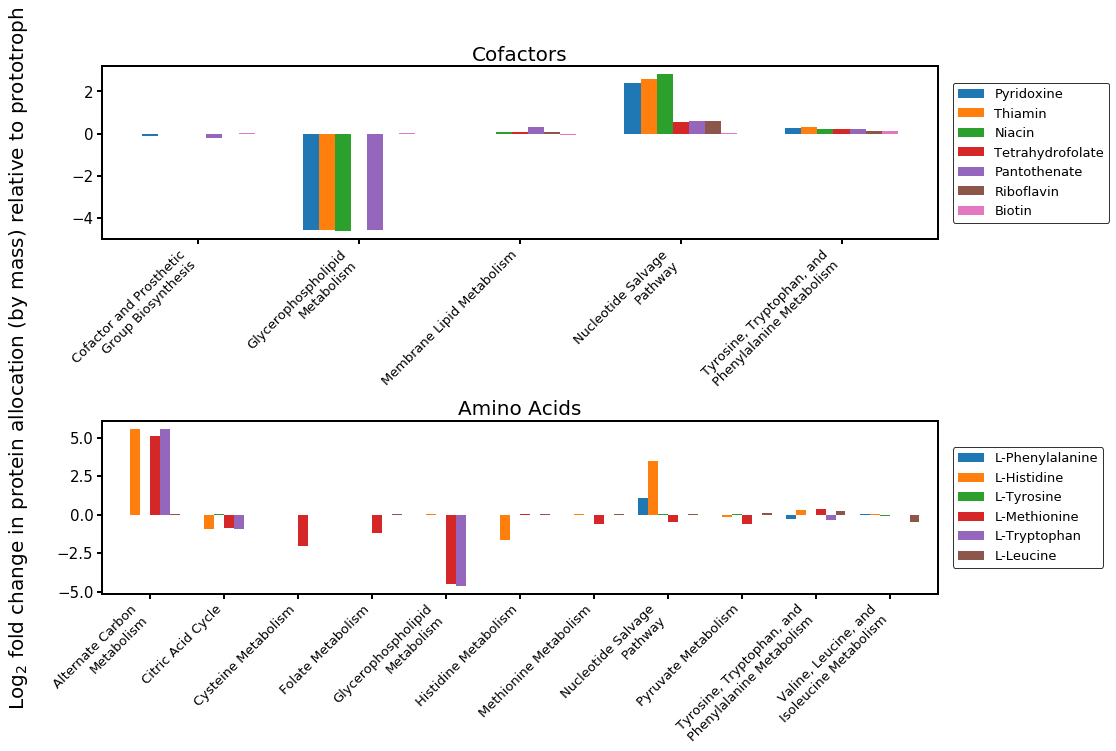

In [23]:
import textwrap
wrapper = textwrap.TextWrapper(width=25)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
cols_to_use = all_df.loc[cofs][abs(all_df.loc[cofs])>.2].dropna(how='all', axis=1).columns
filt_df = all_df.loc[cofs][cols_to_use]
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0], x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__L', x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__R', x))
ax = filt_df.T.plot(kind='bar', width=.7, ax=axes[0])
ax.legend(bbox_to_anchor=(1.01,.5), loc='center left', fontsize=13)
#ax.set_ylabel(r'Log$_2$ fold change in protein allocation'+ '\n(by mass) relative to prototroph')
ax.set_title('Cofactors')
_ =ax.set_xticklabels([wrapper.fill(i.get_text()) for i in ax.get_xticklabels()], rotation=45, ha='right',
                     fontsize=13)

cols_to_use = all_df.loc[aas][abs(all_df.loc[aas])>.2].dropna(how='all', axis=1).columns
filt_df = all_df.loc[aas][cols_to_use]
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0], x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__L', x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__R', x))
ax=filt_df.T.plot(kind='bar', width=.8, ax=axes[1])
ax.legend(bbox_to_anchor=(1.01,.5), loc='center left', fontsize=13)
#ax.set_ylabel(r'Log$_2$ fold change in protein allocation'+ '\n(by mass) relative to prototroph')
ax.set_title('Amino Acids')
_ =ax.set_xticklabels([wrapper.fill(i.get_text()) for i in ax.get_xticklabels()], rotation=45, ha='right',
                     fontsize=13)
fig.tight_layout()

fig.text(-.02, .55, r'Log$_2$ fold change in protein allocation (by mass) relative to prototroph', rotation=90,
         horizontalalignment='center', verticalalignment='center', fontsize=20)

In [25]:
import seaborn as sns
pca_df = pd.DataFrame(pca_dict)
pca_df = pca_df.T[[i for i in pca_df.index if 'DM_RNA' not in i]].T
cons_pca_df = pca_df.copy()
cons_pca_df = cons_pca_df.T
cons_pca_df['metabolite'] = list(cons_pca_df.index)
cons_pca_df['uptake'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[-1]).map(float)
cons_pca_df['metabolite'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[0])
cons_pca_df = cons_pca_df.drop('metabolite', axis=1)
cons_pca_df = cons_pca_df.T[abs(cons_pca_df.sum())>0]
cons_pca_df = abs(cons_pca_df)
cons_pca_df = cons_pca_df.clip_lower(1e-5).applymap(log10)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:12 FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


In [26]:
corr_df = cons_pca_df[[i for i in cons_pca_df.columns if '_'.join(i.split('_')[:-1]) not in aas]]

In [28]:
cons_pca_df

,pydxn_1.2718136132340365e-05,pydxn_2.543627226468073e-05,pydxn_3.815440839702109e-05,pydxn_5.087254452936146e-05,pydxn_6.359068066170183e-05,pydxn_7.63088167940422e-05,pydxn_8.902695292638255e-05,pydxn_0.00010174508905872292,pydxn_0.00011446322519106328,pydxn_0.00012718136132340365,...,tyr__L_0.1237450362217872,tyr__L_0.1349945849692224,tyr__L_0.1462441337166576,tyr__L_0.1574936824640928,tyr__L_0.168743231211528,tyr__L_0.1799927799589632,tyr__L_0.1912423287063984,tyr__L_0.2024918774538336,tyr__L_0.2137414262012688,tyr__L_0.224990974948704
2AGPE160tipp,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000
2AGPEAT160,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000
2AGPG160tipp,-2.444058,-2.444057,-2.444057,-2.444057,-2.444056,-2.444056,-2.444056,-2.444056,-2.444055,-2.444055,...,-2.444056,-2.444055,-2.444057,-2.444059,-2.444055,-2.444059,-2.444054,-2.444054,-2.444054,-2.444054
2AGPGAT160,-2.444058,-2.444057,-2.444057,-2.444057,-2.444056,-2.444056,-2.444056,-2.444056,-2.444055,-2.444055,...,-2.444056,-2.444055,-2.444057,-2.444059,-2.444055,-2.444059,-2.444054,-2.444054,-2.444054,-2.444054
5DOAN,-4.515724,-4.353976,-4.258325,-4.189782,-4.136157,-4.092006,-4.054419,-4.021654,-3.992586,-3.966442,...,-4.007032,-3.976578,-3.948422,-3.922212,-3.897727,-3.874731,-3.853050,-3.832554,-3.813089,-3.798036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_zn2_e,-4.244758,-4.032359,-3.907293,-3.818156,-3.748750,-3.691846,-3.643581,-3.601647,-3.564554,-3.531284,...,-3.587634,-3.548552,-3.512513,-3.479205,-3.448020,-3.418802,-3.391315,-3.365350,-3.340776,-3.376007
EX_RNase_m5,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000
EX_RNase_m16,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000
EX_RNase_m23,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000


In [44]:
tmp = cons_rxn_df[[i for i in cons_rxn_df.columns if i not in ['metabolite', 'uptake']]]

In [ ]:
vi

In [57]:
import escher
view = escher.Builder("iJO1366.Central metabolism", hide_secondary_metabolites=True)
view.reaction_data =  [tmp.loc['nac(1.0)'].clip(lower=1e-3).to_dict(),
                       tmp.loc['nac(0.1)'].clip(lower=1e-3).to_dict()]
view.model = ijo

view.display_in_notebook()

In [56]:
import json
with open('/home/sbrg-cjlloyd/Dropbox/reaction_data.json', 'w') as f:
    json.dump([tmp.loc['nac(1.0)'].clip(lower=1e-3).to_dict(),
                       tmp.loc['nac(0.1)'].clip(lower=1e-3).to_dict()], f)

In [49]:
view.reaction_scale